# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_olivier_feature_matrix_noIDs.csv')
time.time() - st

116.14763021469116

In [3]:
df = df.drop('SK_ID_CURR', axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:42<00:00,  1.08s/it]


36

In [5]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758562	valid_1's auc: 0.752345
[200]	training's auc: 0.780137	valid_1's auc: 0.764704
[300]	training's auc: 0.79785	valid_1's auc: 0.774474
[400]	training's auc: 0.809517	valid_1's auc: 0.78035
[500]	training's auc: 0.818656	valid_1's auc: 0.782907
[600]	training's auc: 0.826556	valid_1's auc: 0.784457
[700]	training's auc: 0.833351	valid_1's auc: 0.78597
[800]	training's auc: 0.839789	valid_1's auc: 0.786615
[900]	training's auc: 0.845563	valid_1's auc: 0.78692
[1000]	training's auc: 0.851112	valid_1's auc: 0.787694
[1100]	training's auc: 0.856299	valid_1's auc: 0.788235
[1200]	training's auc: 0.860999	valid_1's auc: 0.788614
[1300]	training's auc: 0.865475	valid_1's auc: 0.789199
[1400]	training's auc: 0.869883	valid_1's auc: 0.789228
[1500]	training's auc: 0.874008	valid_1's auc: 0.789582
[1600]	training's auc: 0.87825	valid_1's auc: 0.789833
[1700]	training's auc: 0.881992	valid_1's auc: 0.790091

[300]	training's auc: 0.798048	valid_1's auc: 0.771868
[400]	training's auc: 0.809714	valid_1's auc: 0.777249
[500]	training's auc: 0.818976	valid_1's auc: 0.780242
[600]	training's auc: 0.826866	valid_1's auc: 0.781929
[700]	training's auc: 0.833877	valid_1's auc: 0.783434
[800]	training's auc: 0.840171	valid_1's auc: 0.784339
[900]	training's auc: 0.845967	valid_1's auc: 0.784835
[1000]	training's auc: 0.851331	valid_1's auc: 0.785101
[1100]	training's auc: 0.856272	valid_1's auc: 0.785748
[1200]	training's auc: 0.861123	valid_1's auc: 0.78621
[1300]	training's auc: 0.865671	valid_1's auc: 0.786427
[1400]	training's auc: 0.869985	valid_1's auc: 0.786655
Early stopping, best iteration is:
[1361]	training's auc: 0.868325	valid_1's auc: 0.786812
Fold  8 AUC : 0.786812
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758713	valid_1's auc: 0.746525
[200]	training's auc: 0.780576	valid_1's auc: 0.759212
[300]	training's auc: 0.798124	valid_1's auc: 0.7

[700]	training's auc: 0.833606	valid_1's auc: 0.79339
[800]	training's auc: 0.839886	valid_1's auc: 0.794257
[900]	training's auc: 0.845792	valid_1's auc: 0.795306
[1000]	training's auc: 0.851084	valid_1's auc: 0.795513
[1100]	training's auc: 0.856331	valid_1's auc: 0.795713
[1200]	training's auc: 0.86125	valid_1's auc: 0.795452
Early stopping, best iteration is:
[1113]	training's auc: 0.856925	valid_1's auc: 0.795778
Fold 16 AUC : 0.795778
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758087	valid_1's auc: 0.758597
[200]	training's auc: 0.77961	valid_1's auc: 0.772427
[300]	training's auc: 0.797361	valid_1's auc: 0.78399
[400]	training's auc: 0.809067	valid_1's auc: 0.79028
[500]	training's auc: 0.818275	valid_1's auc: 0.793116
[600]	training's auc: 0.826127	valid_1's auc: 0.794883
[700]	training's auc: 0.833198	valid_1's auc: 0.796695
[800]	training's auc: 0.839561	valid_1's auc: 0.797311
[900]	training's auc: 0.845533	valid_1's auc: 0.797737


In [6]:
sub.to_csv('./olivier_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv', index=None)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


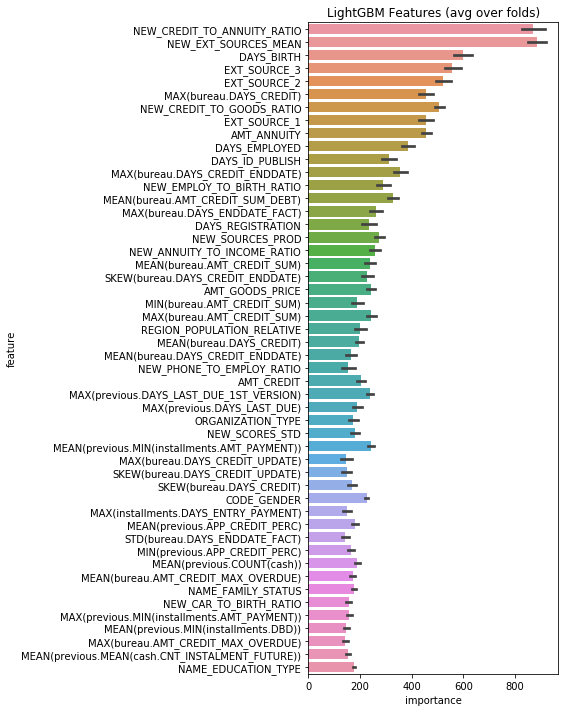

In [8]:
display_importances(feature_importance_df)

In [9]:
time.time() - st

18902.064352989197

In [10]:
feature_importances = feature_importance_df[["feature", "importance"]].groupby("feature").mean()

def norm_feature_importances(df, threshold = 0.95):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

norm_feature_importances = norm_feature_importances(feature_importances)

df = pd.read_csv('./new_feature_by_olivier_feature_matrix_noIDs.csv')
# Threshold for cumulative importance
for threshold in [0.98, 0.96, 0.94, 0.92, 0.9]:

    # Extract the features to keep
    unimportant_features = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] >= threshold]['feature'])    
    df.drop(unimportant_features, axis=1).to_csv('./olivier_feature_matrix_{}.csv'.format(threshold * 100),  index=None)

620 features required for 0.95 of cumulative importance
